In [1]:
import os
from tqdm import tqdm
from itertools import chain
import pandas as pd
import numpy as np
import random, torch
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'white', font_scale=1.5)

In [2]:
import sys

sys.path.insert(0,  '/home/was966/Research/mims-conceptor/')
from conceptor.utils import plot_embed_with_label
from conceptor import PreTrainer, FineTuner, loadconceptor #, get_minmal_epoch
from conceptor.utils import plot_embed_with_label, plot_performance, score2
from conceptor.tokenizer import CANCER_CODE
def onehot(S):
    assert type(S) == pd.Series, 'Input type should be pd.Series'
    dfd = pd.get_dummies(S, dummy_na=True)
    nanidx = dfd[dfd[np.nan].astype(bool)].index
    dfd.loc[nanidx, :] = np.nan
    dfd = dfd.drop(columns=[np.nan])*1.
    cols = dfd.sum().sort_values(ascending=False).index.tolist()
    dfd = dfd[cols]
    return dfd

In [3]:
from conceptor.tokenizer import CONCEPT_palette

In [4]:
import shap
import torch
import torch.nn as nn
from shap import DeepExplainer, KernelExplainer
torch.manual_seed(0)

In [5]:
shap.__version__, np.__version__

('0.44.1', '1.24.3')

In [6]:
## read data
df_label = pd.read_pickle('/home/was966/Research/mims-conceptor/paper//00_data/ITRP.PATIENT.TABLE')
df_tpm = pd.read_pickle('/home/was966/Research/mims-conceptor/paper//00_data/ITRP.TPM.TABLE')
df_tpm.shape, df_label.shape

((1133, 15672), (1133, 110))

In [7]:
s = df_label.groupby('cohort').size()
cancer_type = '_'.join(df_label.cancer_type.unique())

df_tpm = df_tpm.loc[df_label.index]
dfcx = df_label.cancer_type.map(CANCER_CODE).to_frame('cancer_code').join(df_tpm)
df_task = onehot(df_label.response_label)

In [8]:
model_path = '/home/was966/Research/mims-conceptor/paper/checkpoint/latest/finetuner_lft_all.pt'

In [18]:
cancer = 'All'
if cancer  == 'All':
    idx = df_label.index
else:
    idx = df_label[df_label.cancer_type == cancer].index
dfcx = dfcx.loc[idx]
df_task = df_task.loc[idx]

In [9]:
finetuner = loadconceptor(model_path)
device = finetuner.device

dfg, dfc = finetuner.extract(dfcx, batch_size = 32,)
_, dfy = finetuner.predict(dfcx, batch_size = 32,)

model = finetuner.model.taskdecoder
model.eval()

def predict(data):
    model.eval()
    with torch.no_grad():
        data_tensor = torch.tensor(data, dtype=torch.float32)
        return model(data_tensor.to(device)).cpu().numpy()
        
fname = dfc.columns[:]
x = torch.tensor(dfc[fname].values).to(device)

background = x.mean(axis=0).reshape(1,-1)
background.shape

e = KernelExplainer(predict, background.cpu().numpy())
shap_values = e.shap_values(x.cpu().numpy(), check_additivity=True)

100%|##########| 36/36 [00:02<00:00, 16.85it/s]


  0%|          | 0/1133 [00:00<?, ?it/s]

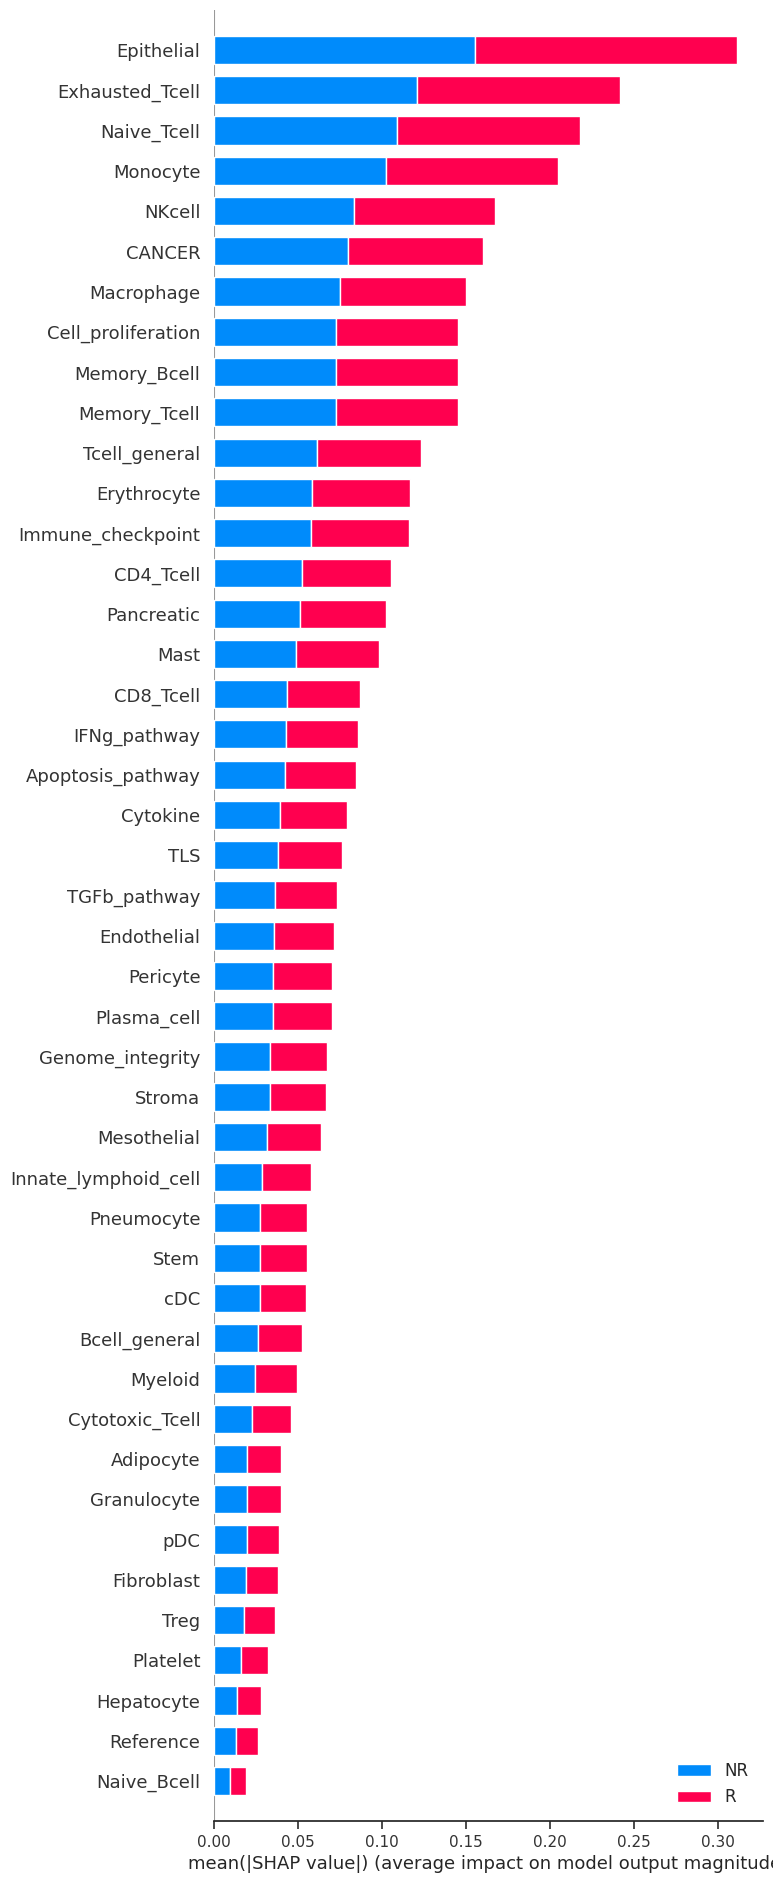

In [16]:
shap.summary_plot(shap_values, x.cpu().numpy(), feature_names = fname, class_names = {0:'NR', 1:'R'}, max_display = 50)

(-0.3, 0.3)

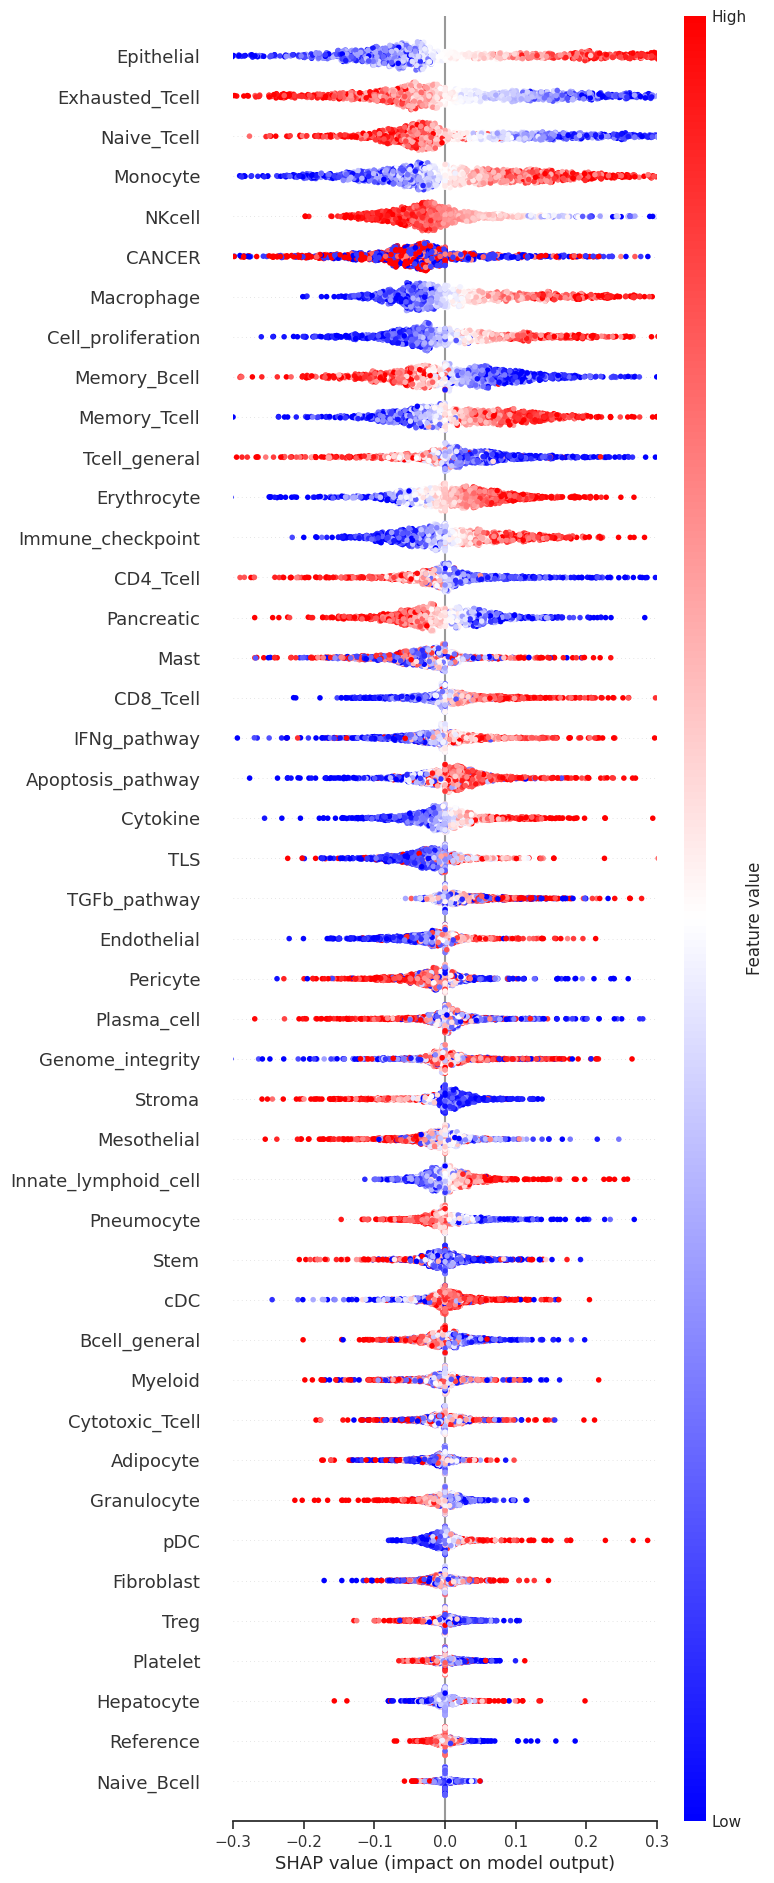

In [17]:
shap.summary_plot(shap_values[1], x.cpu().numpy(), feature_names = fname, 
                  cmap='bwr', plot_type='dot', 
                  class_names = {0:'NR', 1:'R'}, show = False,  max_display = 50)

ax = plt.gca()
ax.set_xlim(-0.3, 0.3)

In [19]:
df1 = pd.DataFrame(shap_values[1], columns = fname, index=dfcx.index)
df1.to_csv('%s_shap_lft_r.csv' % cancer)

df2 = pd.DataFrame(shap_values[0], columns = fname, index=dfcx.index)
df2.to_csv('%s_shap_lft_nr.csv' % cancer)